# Tuned Logistic Regression Model 2

Testing the model with selected features and hyperparameter tunning.

__Imports__

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import jupyterthemes as jt
# context = jt.jtplot.set_context('paper')
# jt.stylefx.style_layout('nb_style', theme='monokai',
#                         toolbar=True, nbname=True, cellwidth='1000')
# jt.stylefx.set_nb_theme('monokai')

In [37]:
jt.jtplot.set_style(context, 'monokai', ticks=True, spines=True)


## Read in the data and instantiate logistic regression model

In [38]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [39]:
feat = ['attribute2', 'attribute4', 'attribute7',
        'attribute8']  # list of features to use base off coeffs.
features = df[feat]
labels = df['failure']

In [41]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    shuffle=False)

In [42]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [43]:
lr = LogisticRegression(penalty='elasticnet',
                        C=0.01,
                        class_weight={1: 5},
                        solver='saga',
                        l1_ratio=0.75)

lr.fit(X_train_ss, y_train)

C:\Users\flake\Anaconda3\envs\ga_dsi\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.01, class_weight={1: 5}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.75, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## LogReg metrics

Accuracy right in line with baseline model

In [53]:
lr.score(X_test_ss, y_test)
# accuracy = 0.998

0.9984256522297905

In [45]:
np.exp(
    lr.coef_
)  # exponentiate because the initial coefficents are the log of the odds.

array([[1.12913629, 1.07333549, 1.08186729, 1.08186729]])

**Coefficients (odds of failing):**

- `attribute2` = $1.13$
- `attribute4` = $1.07$
- `attribute7` = $1.08$
- `attribute8` = $1.08$


In [46]:
# Generate predictions.
preds = lr.predict(X_test)

In [47]:
# Generate confusion matrix.
confusion_matrix(
    y_test,  # True values.
    preds)  # Predicted values

array([[29475,  1623],
       [   11,    15]], dtype=int64)

In [59]:
con_mat = confusion_matrix(y_test, preds)

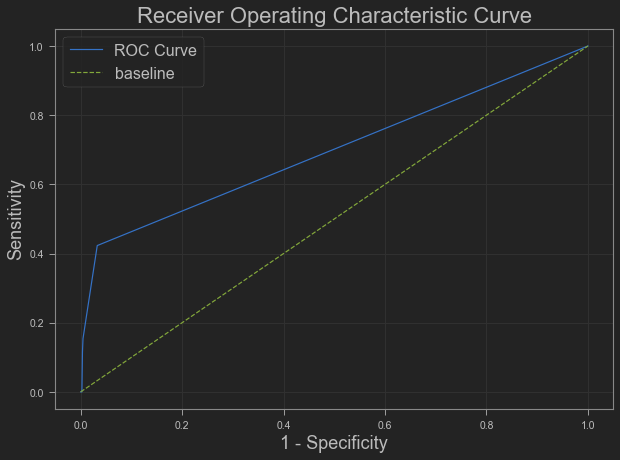

In [51]:
# Create figure.
plt.figure(figsize=(10, 7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)


def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)


def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

In [48]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [49]:
# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9478
Sensitivity: 0.5769


### ROC AUC 

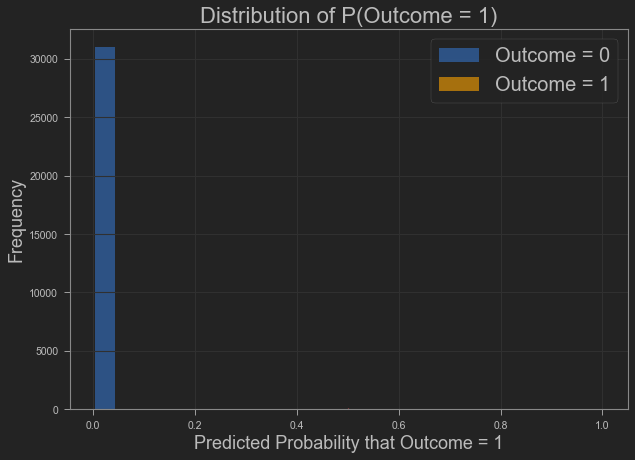

In [50]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_ss)]

pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

# Create figure.
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20)

In [52]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8470177404433626

## Results

This approach used some hyperparameter tuning: Changing the solver to accomodate `elastic net` and increasing the penalty.  I also considered that the devices that fail run each day up until they fail so the time series could be an important aspect.  The exact date doesn't matter since each there didn't seem to be a direct dependence on the date.